<a href="https://colab.research.google.com/github/redrum88/tensorflow/blob/main/10_time_series_forecasting_with_tensorflow_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠️ **Note:** This is not financial advice.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code/text: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/

## Get data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-07 20:12:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-03-07 20:12:24 (11.0 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We've collected the historical price of Bitcoin for the past 8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples.

A smaller number of samples is something you'll often run into  with time series data problems. 

> 🔑 **Note:** The **seasonality** of time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.



In [4]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


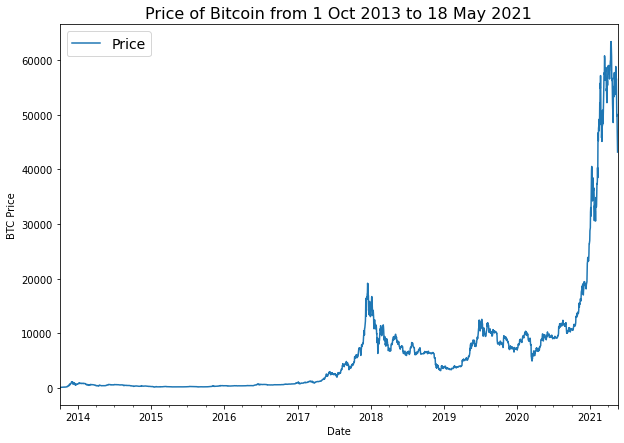

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [6]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime
timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

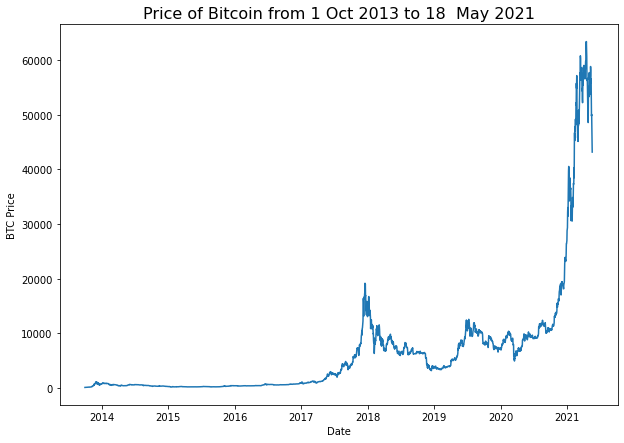

In [7]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps,
         btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18  May 2021", fontsize=16)
plt.xlabel("Date");


## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [8]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [9]:
# Wrong way to make train/test sets for timeseries data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

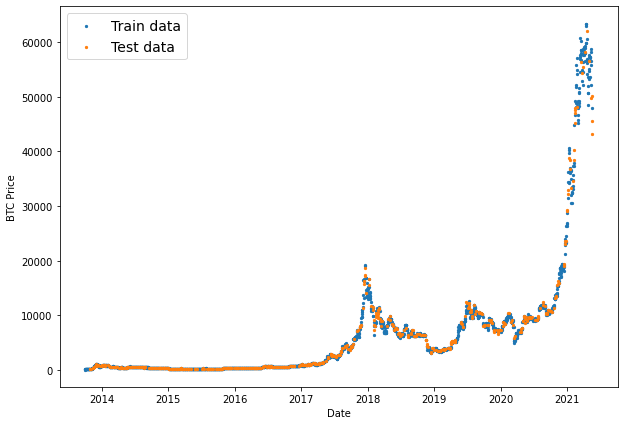

In [10]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)


In [11]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

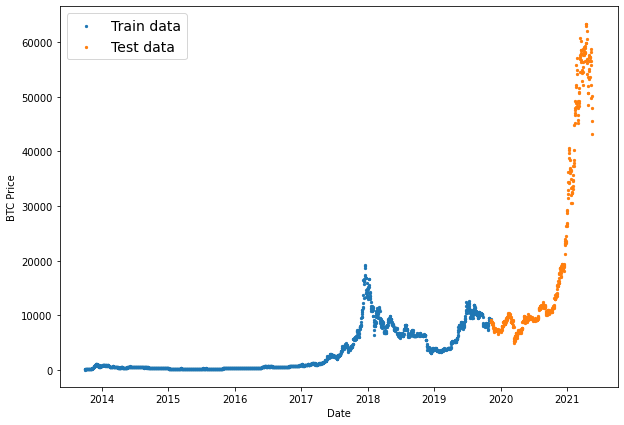

In [12]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [13]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

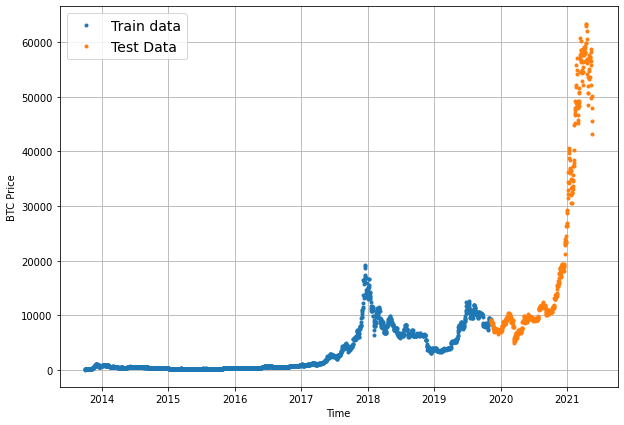

In [14]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict horizon

Modelling experiments we're running:
* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey 🦃 data introduced)


## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [15]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

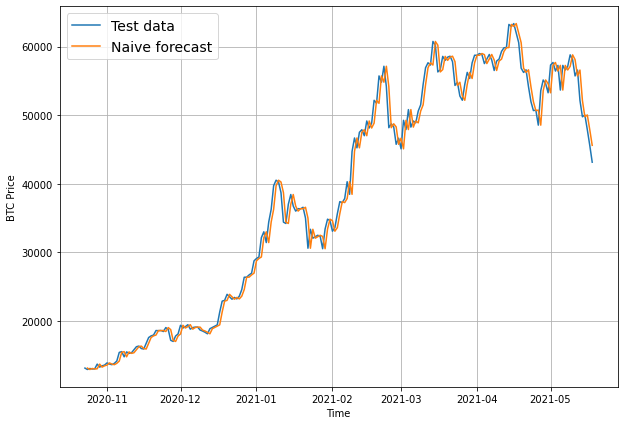

In [16]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive forecast")

> ⚒️ **Exercise:** Spend 10 minutes reading the simple forecasts chapter of Forecasting: Principles in Practice. An have a search to find out why the naive forecast is hard to beat, does the term augoregressive come up?

from IPython.core.magic import error
## Evaluating a time series model

Let's take into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that mean we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RSME - root mean suare error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
+ MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than a MAE of 100.

The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?

In [17]:
import tensorflow as tf

In [18]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Calculates the mean absolute scaled error (MASE) between true and predicted values.

  The MASE measures the relative performance of a forecasting model compared to a naive (naïve2) forecast.
  The MASE is a scaling factor that scales the mean absolute error (MAE) of the forecast to account for the scale
  of the data and the forecast horizon. A MASE of 1 indicates that the forecasting model performs as well as a
  naive forecast, while a MASE < 1 indicates that the model outperforms the naive forecast.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A scalar value representing the MASE between y_true and y_pred.
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day, hence the shift of 1

  return mae / mae_naive_no_season

In [19]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [20]:
# Create a function to evaluate model forecasts with various metrics
def evaluate_preds(y_true, y_pred):
  """
  Evaluates model predictions with various metrics.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A dictionary of evaluation metrics, including:
          - 'mae': mean absolute error
          - 'mse': mean squared error
          - 'rmse': root mean squared error
          - 'mape': mean absolute percentage error
          - 'mase': mean absolute scaled error
  """
  # Make sure float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [21]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [22]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [23]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [24]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [25]:
len(y_train)

2229

In [26]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [27]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use past week of Bitcoin data to make the prediction


In [28]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
    Given a data matrix 'x', return a pair of matrices containing labelled and windowed segments of the data.

    Parameters:
        - x (ndarray): A 2-dimensional matrix of shape (T, D), where T is the number of timesteps and
          D is the number of dimensions.
        - horizon (int): The number of timesteps to include in the window.
        
    Returns:
        - A tuple containing two 2-dimensional matrices of shape (T - horizon, horizon) and (T - horizon, 1),
          respectively. The first matrix contains the windowed segments of the input data, and the second matrix
          contains the labels that correspond to each window.
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 5, 6],
[1, 2, 3, 5, 6, 7],
[2, 3, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

In [30]:
import numpy as np
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Creates windowed data from a target time series.

  Parameters:
      - x (ndarray): A 1-dimensional array containing the target time series.
      - window_size (int): The size of the window to use to create the data (default: WINDOW_SIZE).
      - horizon (int): The number of timesteps into the future to predict (default: HORIZON).

  Returns:
      - A tuple containing two 2-dimensional arrays of shape (N, window_size) and (N, horizon),
        respectively. The first array contains the windowed segments of the input data, and the
        second array contains the labels that correspond to each window.

  Example usage:
  ```python
  # Load some example data
  target_series = np.loadtxt('target_series.txt')

  # Create windowed data with a window size of 30 and a horizon of 1
  X, y = make_windows(target_series, window_size=30, horizon=1)
  ```
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (a time series) with 2D araay of multiple window steps
  windowed_array = x[window_indexes]
  
  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [32]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [33]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [34]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.

  Parameters:
       - windows (ndarray): A 2-dimensional matrix of shape (N, W), where N is the number of windows
        and W is the window size.
      - labels (ndarray): A 2-dimensional matrix of shape (N, H), where N is the number of windows
        and H is the horizon (i.e. the number of timesteps to predict into the future).
      - test_split (float): The proportion of data to allocate for the test split. Defaults to 0.2.

  Returns:
      - A tuple containing four 2-dimensional matrices: (train_windows, test_windows, train_labels, test_labels).
        The training windows and labels are the first two elements of the tuple and represent the training split of
        the input data, while the test windows and labels are the last two elements of the tuple and represent the
        test split of the input data.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [35]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [36]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [37]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [38]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [39]:
import os

# Create a function to implement a modelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  """
  Creates a Keras callback to save the best version of a trained model during training.

  Args:
      model_name (str): A string with the name of the model. This will be used as the prefix of the checkpoint file.
      save_path (str): A string with the directory path where the checkpoint file will be saved. Defaults to "model_experiments".

  Returns:
      A Keras `ModelCheckpoint` callback instance with the specified settings.
  """
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)


## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.

* *Hyperparameters* = values a machine learning practitioner can adjust themselves
* **Parameters** = values a model learns on its own


In [40]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1_history = model_1.fit(train_windows, train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 1183.2183 - mae: 1183.2183 - mse: 4993770.0000   

18/18 [==============================] - 7s 48ms/step - loss: 1083.7233 - mae: 1083.7233 - mse: 4396292.0000 - val_loss: 2886.4395 - val_mae: 2886.4397 - val_mse: 19339946.0000
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 436.5959 - mae: 436.5959 - mse: 844426.6875

18/18 [==============================] - 1s 29ms/step - loss: 302.4299 - mae: 302.4299 - mse: 400877.3750 - val_loss: 1111.2694 - val_mae: 1111.2694 - val_mse: 4082028.7500
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 147.0569 - mae: 147.0569 - mse: 87295.5391

18/18 [==============================] - 0s 28ms/step - loss: 211.4639 - mae: 211.4639 - mse: 212407.9531 - val_loss: 1106.4866 - val_mae: 1106.4866 - val_mse: 3912538.2500
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 196.5836 - mae: 196.5836 - mse: 202089.4219

18/18 [==============================] - 1s 29ms/step - loss: 196.0092 - mae: 196.0092 - mse: 199256.0625 - val_loss: 1050.2281 - val_mae: 1050.2281 - val_mse: 3683924.7500
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 194.0955 - mae: 194.0955 - mse: 130777.0703

18/18 [==============================] - 1s 32ms/step - loss: 189.5438 - mae: 189.5438 - mse: 188739.2031 - val_loss: 1016.7887 - val_mae: 1016.7887 - val_mse: 3415843.0000
Epoch 6/100
13/18 [====================>.........] - ETA: 0s - loss: 178.2078 - mae: 178.2078 - mse: 155041.4844

18/18 [==============================] - 1s 43ms/step - loss: 182.6873 - mae: 182.6873 - mse: 172371.8906 - val_loss: 974.3739 - val_mae: 974.3739 - val_mse: 3234659.0000
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 179.1784 - mae: 179.1784 - mse: 169087.1719

18/18 [==============================] - 1s 42ms/step - loss: 173.9901 - mae: 173.9901 - mse: 158919.0781 - val_loss: 963.0278 - val_mae: 963.0278 - val_mse: 3013414.5000
Epoch 8/100
13/18 [====================>.........] - ETA: 0s - loss: 167.6929 - mae: 167.6929 - mse: 153781.4375

18/18 [==============================] - 1s 41ms/step - loss: 166.3680 - mae: 166.3680 - mse: 150035.2812 - val_loss: 909.4664 - val_mae: 909.4664 - val_mse: 2803747.0000
Epoch 9/100
17/18 [===========================>..] - ETA: 0s - loss: 164.5585 - mae: 164.5585 - mse: 145295.0938

18/18 [==============================] - 1s 29ms/step - loss: 164.2902 - mae: 164.2902 - mse: 144129.9375 - val_loss: 894.3029 - val_mae: 894.3029 - val_mse: 2634803.5000
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 171.8124 - mae: 171.8124 - mse: 212323.9688

18/18 [==============================] - 0s 28ms/step - loss: 160.3596 - mae: 160.3596 - mse: 139573.3594 - val_loss: 862.0986 - val_mae: 862.0986 - val_mse: 2459742.5000
Epoch 11/100
18/18 [==============================] - ETA: 0s - loss: 152.3916 - mae: 152.3916 - mse: 126308.3203

18/18 [==============================] - 1s 40ms/step - loss: 152.3916 - mae: 152.3916 - mse: 126308.3203 - val_loss: 844.1241 - val_mae: 844.1241 - val_mse: 2318657.0000
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 146.9731 - mae: 146.9731 - mse: 119571.8750 - val_loss: 851.3699 - val_mae: 851.3699 - val_mse: 2256684.0000
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 143.4307 - mae: 143.4307 - mse: 114465.6797 - val_loss: 852.0983 - val_mae: 852.0983 - val_mse: 2198795.0000
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 147.0966 - mae: 147.0966 - mse: 97646.1016

18/18 [==============================] - 0s 28ms/step - loss: 138.9294 - mae: 138.9294 - mse: 107554.7031 - val_loss: 805.1741 - val_mae: 805.1741 - val_mse: 2014580.0000
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 138.7548 - mae: 138.7548 - mse: 72010.2188

18/18 [==============================] - 0s 28ms/step - loss: 141.4156 - mae: 141.4156 - mse: 107106.5469 - val_loss: 777.7911 - val_mae: 777.7911 - val_mse: 1899673.7500
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 121.2259 - mae: 121.2259 - mse: 65590.3750

18/18 [==============================] - 0s 29ms/step - loss: 131.9692 - mae: 131.9692 - mse: 97350.9844 - val_loss: 769.5383 - val_mae: 769.5383 - val_mse: 1842945.1250
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 128.0005 - mae: 128.0005 - mse: 93429.4844 - val_loss: 793.1602 - val_mae: 793.1602 - val_mse: 1878932.3750
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 148.6333 - mae: 148.6333 - mse: 111853.6562

18/18 [==============================] - 0s 28ms/step - loss: 128.1385 - mae: 128.1385 - mse: 93251.2266 - val_loss: 692.0797 - val_mae: 692.0797 - val_mse: 1588577.1250
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 122.9799 - mae: 122.9799 - mse: 88720.1328 - val_loss: 718.0586 - val_mae: 718.0586 - val_mse: 1628049.5000
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 119.5611 - mae: 119.5611 - mse: 84420.0938 

18/18 [==============================] - 0s 29ms/step - loss: 120.2868 - mae: 120.2868 - mse: 85489.8047 - val_loss: 676.8947 - val_mae: 676.8947 - val_mse: 1572016.1250
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 151.8075 - mae: 151.8075 - mse: 104381.9297

18/18 [==============================] - 0s 28ms/step - loss: 123.9356 - mae: 123.9356 - mse: 89745.4219 - val_loss: 649.7156 - val_mae: 649.7156 - val_mse: 1452166.6250
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 120.2871 - mae: 120.2871 - mse: 85089.9141 - val_loss: 659.1852 - val_mae: 659.1852 - val_mse: 1446870.3750
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 117.4711 - mae: 117.4711 - mse: 61965.3672

18/18 [==============================] - 0s 28ms/step - loss: 119.2133 - mae: 119.2133 - mse: 82058.2500 - val_loss: 639.3697 - val_mae: 639.3697 - val_mse: 1427489.6250
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 126.3280 - mae: 126.3280 - mse: 85023.7500

18/18 [==============================] - 0s 28ms/step - loss: 118.2348 - mae: 118.2348 - mse: 84067.6562 - val_loss: 632.8404 - val_mae: 632.8404 - val_mse: 1379128.3750
Epoch 25/100
18/18 [==============================] - ETA: 0s - loss: 115.6036 - mae: 115.6036 - mse: 80108.7969

18/18 [==============================] - 0s 29ms/step - loss: 115.6036 - mae: 115.6036 - mse: 80108.7969 - val_loss: 623.1769 - val_mae: 623.1769 - val_mse: 1361077.2500
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 117.5968 - mae: 117.5968 - mse: 80653.1562 - val_loss: 625.0632 - val_mae: 625.0632 - val_mse: 1347329.6250
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 118.5599 - mae: 118.5599 - mse: 79237.0078 

18/18 [==============================] - 1s 30ms/step - loss: 118.5599 - mae: 118.5599 - mse: 79237.0078 - val_loss: 613.6901 - val_mae: 613.6901 - val_mse: 1326104.2500
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 113.4363 - mae: 113.4363 - mse: 78013.6562

18/18 [==============================] - 0s 29ms/step - loss: 113.4363 - mae: 113.4363 - mse: 78013.6562 - val_loss: 610.4299 - val_mae: 610.4299 - val_mse: 1318284.3750
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 113.1438 - mae: 113.1438 - mse: 77215.2578 - val_loss: 612.8921 - val_mae: 612.8921 - val_mse: 1309287.6250
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 128.2610 - mae: 128.2610 - mse: 90704.4766

18/18 [==============================] - 1s 29ms/step - loss: 119.1222 - mae: 119.1222 - mse: 80217.7109 - val_loss: 605.4277 - val_mae: 605.4277 - val_mse: 1302024.2500
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 119.2832 - mae: 119.2832 - mse: 63913.9062

18/18 [==============================] - 0s 28ms/step - loss: 118.0203 - mae: 118.0203 - mse: 77547.8516 - val_loss: 603.4846 - val_mae: 603.4846 - val_mse: 1285142.7500
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5729 - mae: 112.5729 - mse: 77666.5547 - val_loss: 620.9178 - val_mae: 620.9178 - val_mse: 1313746.3750
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 112.4469 - mae: 112.4469 - mse: 75525.2578 - val_loss: 627.7119 - val_mae: 627.7119 - val_mse: 1324888.6250
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 113.7382 - mae: 113.7382 - mse: 77725.1562 - val_loss: 604.6687 - val_mae: 604.6687 - val_mse: 1275995.1250
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 112.1130 - mae: 112.1130 - mse: 76520.3516 - val_loss: 617.7783 - val_mae: 617.7783 - val_mse: 1325567.2500
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 157.6791 - mae: 157.6791 - mse: 

18/18 [==============================] - 1s 46ms/step - loss: 113.9213 - mae: 113.9213 - mse: 76505.0781 - val_loss: 594.2988 - val_mae: 594.2988 - val_mse: 1255535.2500
Epoch 37/100
18/18 [==============================] - 0s 8ms/step - loss: 110.5730 - mae: 110.5730 - mse: 74893.7500 - val_loss: 595.8834 - val_mae: 595.8834 - val_mse: 1258233.3750
Epoch 38/100
18/18 [==============================] - 0s 8ms/step - loss: 112.2514 - mae: 112.2514 - mse: 75572.9844 - val_loss: 595.5646 - val_mae: 595.5646 - val_mse: 1264551.0000
Epoch 39/100
15/18 [========================>.....] - ETA: 0s - loss: 113.0554 - mae: 113.0554 - mse: 78678.4297 

18/18 [==============================] - 1s 40ms/step - loss: 109.9045 - mae: 109.9045 - mse: 74082.2109 - val_loss: 588.4642 - val_mae: 588.4642 - val_mse: 1243244.1250
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 109.3077 - mae: 109.3077 - mse: 73081.6797 - val_loss: 611.5674 - val_mae: 611.5674 - val_mse: 1305791.2500
Epoch 41/100
15/18 [========================>.....] - ETA: 0s - loss: 112.3981 - mae: 112.3981 - mse: 79380.0078

18/18 [==============================] - 1s 40ms/step - loss: 109.5471 - mae: 109.5471 - mse: 73964.4219 - val_loss: 587.2724 - val_mae: 587.2724 - val_mse: 1245424.3750
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 116.7493 - mae: 116.7493 - mse: 79412.6953 - val_loss: 669.2827 - val_mae: 669.2827 - val_mse: 1400775.8750
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 118.3153 - mae: 118.3153 - mse: 75537.5781 - val_loss: 676.9460 - val_mae: 676.9460 - val_mse: 1461341.5000
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 116.8979 - mae: 116.8979 - mse: 76654.3672 - val_loss: 591.1383 - val_mae: 591.1383 - val_mse: 1231014.5000
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 108.7188 - mae: 108.7188 - mse: 73567.5312 - val_loss: 603.1702 - val_mae: 603.1702 - val_mse: 1279052.3750
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1515 - mae: 111.1515 - m

18/18 [==============================] - 0s 28ms/step - loss: 109.7864 - mae: 109.7864 - mse: 73332.7812 - val_loss: 579.1621 - val_mae: 579.1621 - val_mse: 1204582.3750
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4029 - mae: 111.4029 - mse: 74207.0469 - val_loss: 611.5174 - val_mae: 611.5174 - val_mse: 1259603.6250
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 108.8008 - mae: 108.8008 - mse: 71709.5938 - val_loss: 581.8612 - val_mae: 581.8612 - val_mse: 1219638.1250
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5590 - mae: 112.5590 - mse: 75384.3281 - val_loss: 658.6190 - val_mae: 658.6190 - val_mse: 1364335.1250
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 114.5504 - mae: 114.5504 - mse: 74502.2266 - val_loss: 782.4730 - val_mae: 782.4730 - val_mse: 1789911.8750
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 124.0382 - mae: 124.0382 - m

18/18 [==============================] - 0s 28ms/step - loss: 111.6277 - mae: 111.6277 - mse: 75190.7422 - val_loss: 575.1708 - val_mae: 575.1708 - val_mse: 1198383.5000
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 108.1395 - mae: 108.1395 - mse: 71131.2188 - val_loss: 577.7438 - val_mae: 577.7438 - val_mse: 1204570.1250
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 113.4010 - mae: 113.4010 - mse: 74294.5156 - val_loss: 652.9599 - val_mae: 652.9599 - val_mse: 1349070.5000
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5661 - mae: 112.5661 - mse: 73553.6719 - val_loss: 576.2109 - val_mae: 576.2109 - val_mse: 1191748.3750
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 107.7595 - mae: 107.7595 - mse: 71436.6094 - val_loss: 575.4833 - val_mae: 575.4833 - val_mse: 1188696.2500
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3999 - mae: 108.3999 - m

18/18 [==============================] - 0s 28ms/step - loss: 108.9524 - mae: 108.9524 - mse: 71479.6484 - val_loss: 570.6370 - val_mae: 570.6370 - val_mse: 1178228.2500
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 108.7602 - mae: 108.7602 - mse: 71150.7734 - val_loss: 574.2693 - val_mae: 574.2693 - val_mse: 1190537.5000
Epoch 78/100
17/18 [===========================>..] - ETA: 0s - loss: 109.0818 - mae: 109.0818 - mse: 71076.1797

18/18 [==============================] - 1s 29ms/step - loss: 108.0060 - mae: 108.0060 - mse: 69794.2734 - val_loss: 570.2494 - val_mae: 570.2494 - val_mse: 1178599.5000
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 107.1931 - mae: 107.1931 - mse: 71612.0000 - val_loss: 582.7483 - val_mae: 582.7483 - val_mse: 1205016.7500
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 107.8278 - mae: 107.8278 - mse: 71639.5078 - val_loss: 590.1223 - val_mae: 590.1223 - val_mse: 1205603.5000
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 108.5718 - mae: 108.5718 - mse: 71388.7969 - val_loss: 573.0217 - val_mae: 573.0217 - val_mse: 1187360.0000
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 116.1531 - mae: 116.1531 - mse: 76699.2188 - val_loss: 576.0864 - val_mae: 576.0864 - val_mse: 1180413.0000
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6464 - mae: 114.6464 - m

18/18 [==============================] - 1s 29ms/step - loss: 112.4630 - mae: 112.4630 - mse: 73386.0078 - val_loss: 567.0259 - val_mae: 567.0259 - val_mse: 1164037.0000
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 115.6467 - mae: 115.6467 - mse: 75176.2969 - val_loss: 596.4235 - val_mae: 596.4235 - val_mse: 1232844.0000
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5408 - mae: 112.5408 - mse: 73551.3984 - val_loss: 579.4014 - val_mae: 579.4014 - val_mse: 1182396.6250
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8770 - mae: 106.8770 - mse: 68825.2969 - val_loss: 570.5707 - val_mae: 570.5707 - val_mse: 1174527.2500
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 106.5617 - mae: 106.5617 - mse: 70004.5156 - val_loss: 595.2145 - val_mae: 595.2145 - val_mse: 1233552.3750
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 106.6240 - mae: 106.6240 - m

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [42]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 595.7908 - mae: 595.7908 - mse: 1212195.8750


[595.7908325195312, 595.7908325195312, 1212195.875]

In [43]:
# Loading in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 567.0258 - mae: 567.0258 - mse: 1164036.8750


[567.0257568359375, 567.0257568359375, 1164036.875]

## Make forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions




In [44]:
def make_preds(model, input_data):
  """
  Generates a prediction (forecast) for the given `input_data` using the `model`.

  Args:
      model (object): A trained machine learning model capable of making predictions.
      input_data (object): Input data in the format expected by the `model`.

  Returns:
      The forecast generated by the `model` for the given `input_data`, as a one-dimensional tensor.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [45]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8875.01 , 8783.675, 9041.797, 8798.737, 8736.251, 8754.349,
        8697.968, 8532.117, 8468.885, 8539.21 ], dtype=float32)>)

In [46]:
test_labels[:10]

array([[8798.04205463],
       [9081.18687849],
       [8711.53433917],
       [8760.89271814],
       [8749.52059102],
       [8656.97092235],
       [8500.64355816],
       [8469.2608989 ],
       [8537.33965197],
       [8205.80636599]])

In [47]:
# Evaluate preds
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': 567.0257,
 'mse': 1164036.9,
 'rmse': 1078.9054,
 'mape': 2.549461,
 'mase': 0.9961071}

In [48]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

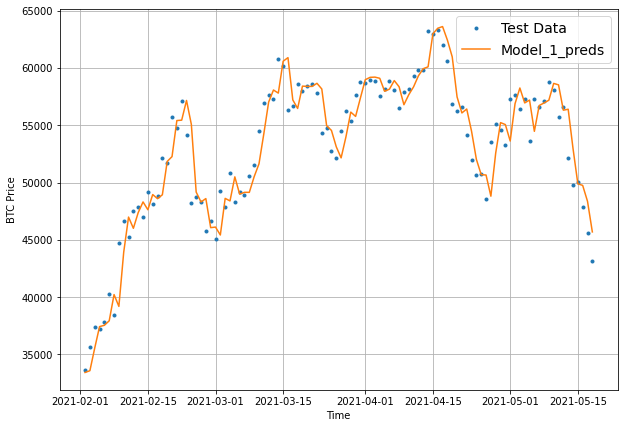

In [49]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="Model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

In [50]:
HORIZON = 1
WINDOW_SIZE = 30


In [51]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [52]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2205, 2205, 552, 552)

In [53]:
tf.random.set_seed(42)

# Create a model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# Fit the model
model_2_history = model_2.fit(train_windows, train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint("model_2_dense")])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1732.9385 - mae: 1732.9385 - mse: 11811144.0000 

18/18 [==============================] - 2s 56ms/step - loss: 1715.6073 - mae: 1715.6073 - mse: 11669114.0000 - val_loss: 3141.4539 - val_mae: 3141.4539 - val_mse: 26222370.0000
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 562.8979 - mae: 562.8979 - mse: 1364384.3750

18/18 [==============================] - 1s 56ms/step - loss: 554.2806 - mae: 554.2806 - mse: 1336602.6250 - val_loss: 2842.5508 - val_mae: 2842.5508 - val_mse: 21387148.0000
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 448.4443 - mae: 448.4443 - mse: 946915.3125 

18/18 [==============================] - 1s 38ms/step - loss: 434.4633 - mae: 434.4633 - mse: 893238.0000 - val_loss: 1933.8365 - val_mae: 1933.8365 - val_mse: 11492036.0000
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 339.7208 - mae: 339.7208 - mse: 562715.1250

18/18 [==============================] - 1s 30ms/step - loss: 342.3115 - mae: 342.3115 - mse: 581033.7500 - val_loss: 1676.0758 - val_mae: 1676.0758 - val_mse: 8856038.0000
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 314.3966 - mae: 314.3966 - mse: 414503.9688

18/18 [==============================] - 1s 29ms/step - loss: 290.4676 - mae: 290.4676 - mse: 421152.1875 - val_loss: 1478.6157 - val_mae: 1478.6157 - val_mse: 7057647.5000
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 346.4350 - mae: 346.4350 - mse: 784279.9375

18/18 [==============================] - 0s 27ms/step - loss: 264.6099 - mae: 264.6099 - mse: 351585.7500 - val_loss: 1448.7716 - val_mae: 1448.7716 - val_mse: 6491205.5000
Epoch 7/100
18/18 [==============================] - ETA: 0s - loss: 240.7663 - mae: 240.7663 - mse: 292750.0938

18/18 [==============================] - 1s 29ms/step - loss: 240.7663 - mae: 240.7663 - mse: 292750.0938 - val_loss: 1445.4164 - val_mae: 1445.4164 - val_mse: 6168098.5000
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 228.6721 - mae: 228.6721 - mse: 254469.7812

18/18 [==============================] - 0s 29ms/step - loss: 233.7202 - mae: 233.7202 - mse: 273916.5938 - val_loss: 1270.5912 - val_mae: 1270.5912 - val_mse: 5374209.0000
Epoch 9/100
17/18 [===========================>..] - ETA: 0s - loss: 222.3995 - mae: 222.3995 - mse: 246257.2188

18/18 [==============================] - 0s 29ms/step - loss: 222.8773 - mae: 222.8773 - mse: 245111.7031 - val_loss: 1219.0634 - val_mae: 1219.0634 - val_mse: 5100932.5000
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 214.2315 - mae: 214.2315 - mse: 236615.4375

18/18 [==============================] - 1s 30ms/step - loss: 213.6980 - mae: 213.6980 - mse: 235291.4531 - val_loss: 1203.7814 - val_mae: 1203.7814 - val_mse: 4533005.0000
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 200.3351 - mae: 200.3351 - mse: 173625.8594

18/18 [==============================] - 0s 29ms/step - loss: 211.4479 - mae: 211.4479 - mse: 220261.3438 - val_loss: 1117.1372 - val_mae: 1117.1372 - val_mse: 4277025.0000
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 192.4306 - mae: 192.4306 - mse: 165543.7500

18/18 [==============================] - 0s 27ms/step - loss: 204.3088 - mae: 204.3088 - mse: 208517.0938 - val_loss: 1074.0046 - val_mae: 1074.0046 - val_mse: 3883095.2500
Epoch 13/100
16/18 [=========================>....] - ETA: 0s - loss: 192.6434 - mae: 192.6434 - mse: 187830.3125

18/18 [==============================] - 1s 30ms/step - loss: 192.6055 - mae: 192.6055 - mse: 187576.7812 - val_loss: 1070.7194 - val_mae: 1070.7194 - val_mse: 3911182.5000
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 242.0149 - mae: 242.0149 - mse: 329323.4375

18/18 [==============================] - 1s 30ms/step - loss: 192.8190 - mae: 192.8190 - mse: 185895.6406 - val_loss: 1022.0900 - val_mae: 1022.0900 - val_mse: 3538026.7500
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 199.6241 - mae: 199.6241 - mse: 182640.7344 - val_loss: 1387.7665 - val_mae: 1387.7665 - val_mse: 5798230.5000
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 201.1855 - mae: 201.1855 - mse: 195033.9844 - val_loss: 1224.9680 - val_mae: 1224.9680 - val_mse: 4716017.5000
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 188.3294 - mae: 188.3294 - mse: 172069.3750 - val_loss: 1230.3014 - val_mae: 1230.3014 - val_mse: 4041762.7500
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 254.9386 - mae: 254.9386 - mse: 250991.2188

18/18 [==============================] - 0s 28ms/step - loss: 172.6487 - mae: 172.6487 - mse: 152452.1562 - val_loss: 937.1039 - val_mae: 937.1039 - val_mse: 2838853.2500
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 162.8416 - mae: 162.8416 - mse: 137884.5781 - val_loss: 1168.5299 - val_mae: 1168.5299 - val_mse: 4212032.5000
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 168.3401 - mae: 168.3401 - mse: 142817.2344 - val_loss: 939.1232 - val_mae: 939.1232 - val_mse: 2914296.2500
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 173.0668 - mae: 173.0668 - mse: 149658.2969 - val_loss: 1122.0380 - val_mae: 1122.0380 - val_mse: 3427233.7500
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 171.4712 - mae: 171.4712 - mse: 126615.7188

18/18 [==============================] - 0s 29ms/step - loss: 182.1008 - mae: 182.1008 - mse: 151593.6875 - val_loss: 907.6937 - val_mae: 907.6937 - val_mse: 2528630.7500
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 164.2949 - mae: 164.2949 - mse: 134923.5469 - val_loss: 1461.1993 - val_mae: 1461.1993 - val_mse: 5116175.5000
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 261.1848 - mae: 261.1848 - mse: 222508.5625

18/18 [==============================] - 1s 42ms/step - loss: 186.4830 - mae: 186.4830 - mse: 156178.8125 - val_loss: 856.3044 - val_mae: 856.3044 - val_mse: 2336776.0000
Epoch 25/100
18/18 [==============================] - 0s 6ms/step - loss: 164.8965 - mae: 164.8965 - mse: 134117.3438 - val_loss: 1355.7887 - val_mae: 1355.7887 - val_mse: 4497028.0000
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 186.0785 - mae: 186.0785 - mse: 97370.7344

18/18 [==============================] - 0s 29ms/step - loss: 171.5172 - mae: 171.5172 - mse: 139501.3906 - val_loss: 854.0707 - val_mae: 854.0707 - val_mse: 2295102.7500
Epoch 27/100
18/18 [==============================] - 0s 6ms/step - loss: 147.1516 - mae: 147.1516 - mse: 115083.6797 - val_loss: 944.2632 - val_mae: 944.2632 - val_mse: 2583590.2500
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 150.3792 - mae: 150.3792 - mse: 114998.2422

18/18 [==============================] - 1s 30ms/step - loss: 152.1226 - mae: 152.1226 - mse: 117267.3281 - val_loss: 837.9695 - val_mae: 837.9695 - val_mse: 2301934.5000
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 146.3315 - mae: 146.3315 - mse: 111631.8047 - val_loss: 1229.5760 - val_mae: 1229.5760 - val_mse: 3825088.5000
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 174.8538 - mae: 174.8538 - mse: 140723.2188 - val_loss: 1245.5751 - val_mae: 1245.5751 - val_mse: 3895068.2500
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 170.0451 - mae: 170.0451 - mse: 138645.5312

18/18 [==============================] - 1s 35ms/step - loss: 170.0451 - mae: 170.0451 - mse: 138645.5312 - val_loss: 793.2141 - val_mae: 793.2141 - val_mse: 2053395.0000
Epoch 32/100
14/18 [======================>.......] - ETA: 0s - loss: 172.8248 - mae: 172.8248 - mse: 136125.1406

18/18 [==============================] - 1s 40ms/step - loss: 169.5506 - mae: 169.5506 - mse: 133872.6094 - val_loss: 783.9991 - val_mae: 783.9991 - val_mse: 2019974.2500
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 147.0213 - mae: 147.0213 - mse: 113925.6797 - val_loss: 836.3457 - val_mae: 836.3457 - val_mse: 2154064.5000
Epoch 34/100
18/18 [==============================] - 0s 10ms/step - loss: 146.6628 - mae: 146.6628 - mse: 111256.7109 - val_loss: 895.2192 - val_mae: 895.2192 - val_mse: 2505825.5000
Epoch 35/100
18/18 [==============================] - 0s 8ms/step - loss: 157.0259 - mae: 157.0259 - mse: 119983.0469 - val_loss: 857.7627 - val_mae: 857.7627 - val_mse: 2324625.5000
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 148.0142 - mae: 148.0142 - mse: 107575.7188 - val_loss: 819.7099 - val_mae: 819.7099 - val_mse: 2082010.8750
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 144.7086 - mae: 144.70

18/18 [==============================] - 1s 40ms/step - loss: 146.2181 - mae: 146.2181 - mse: 105491.6562 - val_loss: 771.1190 - val_mae: 771.1190 - val_mse: 1902682.3750
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 147.6458 - mae: 147.6458 - mse: 159420.9219

18/18 [==============================] - 0s 28ms/step - loss: 139.5350 - mae: 139.5350 - mse: 103407.9062 - val_loss: 756.2651 - val_mae: 756.2651 - val_mse: 1844346.6250
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 136.6304 - mae: 136.6304 - mse: 96811.2734 - val_loss: 919.0157 - val_mae: 919.0157 - val_mse: 2415771.2500
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 134.2950 - mae: 134.2950 - mse: 52369.7969

18/18 [==============================] - 0s 28ms/step - loss: 138.8623 - mae: 138.8623 - mse: 97938.3594 - val_loss: 755.5084 - val_mae: 755.5084 - val_mse: 1830448.7500
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 115.8229 - mae: 115.8229 - mse: 56203.8906

18/18 [==============================] - 0s 28ms/step - loss: 145.3055 - mae: 145.3055 - mse: 104232.0156 - val_loss: 732.4304 - val_mae: 732.4304 - val_mse: 1796743.1250
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 138.1386 - mae: 138.1386 - mse: 98259.0547 - val_loss: 888.2375 - val_mae: 888.2375 - val_mse: 2412609.2500
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 147.0010 - mae: 147.0010 - mse: 110141.6953 - val_loss: 736.7801 - val_mae: 736.7801 - val_mse: 1804096.5000
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 135.3835 - mae: 135.3835 - mse: 95325.6016 - val_loss: 738.7900 - val_mae: 738.7900 - val_mse: 1763601.5000
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 138.8128 - mae: 138.8128 - mse: 95253.2969 - val_loss: 743.0486 - val_mae: 743.0486 - val_mse: 1766395.1250
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 143.7180 - mae: 143.7180 -

18/18 [==============================] - 0s 28ms/step - loss: 137.3798 - mae: 137.3798 - mse: 95964.3203 - val_loss: 722.9830 - val_mae: 722.9830 - val_mse: 1692877.6250
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 155.5717 - mae: 155.5717 - mse: 110014.6875 - val_loss: 810.1567 - val_mae: 810.1567 - val_mse: 2041796.1250
Epoch 54/100
15/18 [========================>.....] - ETA: 0s - loss: 148.2456 - mae: 148.2456 - mse: 105519.3516

18/18 [==============================] - 0s 29ms/step - loss: 147.4844 - mae: 147.4844 - mse: 106137.3672 - val_loss: 698.4666 - val_mae: 698.4666 - val_mse: 1636074.0000
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 141.3748 - mae: 141.3748 - mse: 95337.3594 - val_loss: 1019.9399 - val_mae: 1019.9399 - val_mse: 2729045.2500
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 134.2061 - mae: 134.2061 - mse: 95421.0625 - val_loss: 766.2438 - val_mae: 766.2438 - val_mse: 1831210.6250
Epoch 57/100
18/18 [==============================] - 0s 8ms/step - loss: 134.9365 - mae: 134.9365 - mse: 93987.3281 - val_loss: 775.7480 - val_mae: 775.7480 - val_mse: 1860359.5000
Epoch 58/100
18/18 [==============================] - 0s 18ms/step - loss: 134.4818 - mae: 134.4818 - mse: 95467.1562 - val_loss: 811.6111 - val_mae: 811.6111 - val_mse: 2049309.2500
Epoch 59/100
16/18 [=========================>....] - ETA: 0s - loss: 179.1037 - mae: 179.1037 - m

18/18 [==============================] - 1s 45ms/step - loss: 181.3198 - mae: 181.3198 - mse: 135747.4375 - val_loss: 681.7149 - val_mae: 681.7149 - val_mse: 1564367.6250
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 152.1957 - mae: 152.1957 - mse: 107889.6797 - val_loss: 1266.7407 - val_mae: 1266.7407 - val_mse: 3732986.0000
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 157.5969 - mae: 157.5969 - mse: 108515.5859 - val_loss: 704.8843 - val_mae: 704.8843 - val_mse: 1622541.1250
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 135.4595 - mae: 135.4595 - mse: 93290.1719 - val_loss: 813.9960 - val_mae: 813.9960 - val_mse: 2051266.3750
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 131.5716 - mae: 131.5716 - mse: 91513.5469 - val_loss: 689.3185 - val_mae: 689.3185 - val_mse: 1580668.0000
Epoch 64/100
 1/18 [>.............................] - ETA: 0s - loss: 95.2714 - mae: 95.2714 - ms

18/18 [==============================] - 1s 29ms/step - loss: 123.1399 - mae: 123.1399 - mse: 83844.6484 - val_loss: 672.2307 - val_mae: 672.2307 - val_mse: 1533501.0000
Epoch 65/100
18/18 [==============================] - 0s 6ms/step - loss: 126.5583 - mae: 126.5583 - mse: 87629.2578 - val_loss: 713.2095 - val_mae: 713.2095 - val_mse: 1638874.6250
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 127.4106 - mae: 127.4106 - mse: 88498.6953 - val_loss: 730.1783 - val_mae: 730.1783 - val_mse: 1723269.3750
Epoch 67/100
 1/18 [>.............................] - ETA: 0s - loss: 127.5668 - mae: 127.5668 - mse: 77384.7891

18/18 [==============================] - 0s 28ms/step - loss: 126.3108 - mae: 126.3108 - mse: 86894.5547 - val_loss: 666.1668 - val_mae: 666.1668 - val_mse: 1505898.6250
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 129.0449 - mae: 129.0449 - mse: 88972.6016 - val_loss: 667.1275 - val_mae: 667.1275 - val_mse: 1503586.7500
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 123.4081 - mae: 123.4081 - mse: 83809.0938 - val_loss: 905.3813 - val_mae: 905.3813 - val_mse: 2256641.5000
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 131.0687 - mae: 131.0687 - mse: 90269.3984 - val_loss: 866.7047 - val_mae: 866.7047 - val_mse: 2129540.5000
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 127.4111 - mae: 127.4111 - mse: 86979.9453 - val_loss: 700.6070 - val_mae: 700.6070 - val_mse: 1633296.1250
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 131.1973 - mae: 131.1973 - m

18/18 [==============================] - 1s 44ms/step - loss: 128.0654 - mae: 128.0654 - mse: 87371.7109 - val_loss: 657.6206 - val_mae: 657.6206 - val_mse: 1461957.2500
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 129.9341 - mae: 129.9341 - mse: 71243.6094

18/18 [==============================] - 1s 30ms/step - loss: 130.8023 - mae: 130.8023 - mse: 90605.3984 - val_loss: 656.2291 - val_mae: 656.2291 - val_mse: 1452070.3750
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 134.0415 - mae: 134.0415 - mse: 89942.1016 - val_loss: 858.3563 - val_mae: 858.3563 - val_mse: 2080771.2500
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 129.1664 - mae: 129.1664 - mse: 87686.1562 - val_loss: 742.1776 - val_mae: 742.1776 - val_mse: 1712651.0000
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 125.7644 - mae: 125.7644 - mse: 84480.5000 - val_loss: 858.3569 - val_mae: 858.3569 - val_mse: 2083612.2500
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 140.0003 - mae: 140.0003 - mse: 96185.1484 - val_loss: 691.9286 - val_mae: 691.9286 - val_mse: 1603644.0000
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 119.8789 - mae: 119.8789 - m

18/18 [==============================] - 1s 30ms/step - loss: 125.7420 - mae: 125.7420 - mse: 83058.2500 - val_loss: 648.0286 - val_mae: 648.0286 - val_mse: 1439375.3750
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 119.1881 - mae: 119.1881 - mse: 81299.5547 - val_loss: 658.7855 - val_mae: 658.7855 - val_mse: 1463124.5000
Epoch 83/100
 1/18 [>.............................] - ETA: 0s - loss: 95.2302 - mae: 95.2302 - mse: 53100.0430

18/18 [==============================] - 1s 39ms/step - loss: 126.4976 - mae: 126.4976 - mse: 83913.9297 - val_loss: 645.3412 - val_mae: 645.3412 - val_mse: 1419044.0000
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 124.9244 - mae: 124.9244 - mse: 83056.1250 - val_loss: 942.2816 - val_mae: 942.2816 - val_mse: 2369544.0000
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 132.8831 - mae: 132.8831 - mse: 90462.9922 - val_loss: 771.8579 - val_mae: 771.8579 - val_mse: 1784736.7500
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 145.8027 - mae: 145.8027 - mse: 95689.2266 - val_loss: 701.7620 - val_mae: 701.7620 - val_mse: 1573840.7500
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 131.6853 - mae: 131.6853 - mse: 86800.0000 - val_loss: 696.6580 - val_mae: 696.6580 - val_mse: 1567705.5000
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 137.0565 - mae: 137.0565 - m

18/18 [==============================] - 1s 41ms/step - loss: 136.7863 - mae: 136.7863 - mse: 90032.7422 - val_loss: 636.5494 - val_mae: 636.5494 - val_mse: 1393036.6250
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 127.5704 - mae: 127.5704 - mse: 85933.1484 - val_loss: 657.7929 - val_mae: 657.7929 - val_mse: 1474197.7500
Epoch 92/100
18/18 [==============================] - 0s 8ms/step - loss: 122.3377 - mae: 122.3377 - mse: 81727.1484 - val_loss: 735.6799 - val_mae: 735.6799 - val_mse: 1669074.1250
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 139.7157 - mae: 139.7157 - mse: 89691.2734 - val_loss: 946.6311 - val_mae: 946.6311 - val_mse: 2358924.0000
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 138.2180 - mae: 138.2180 - mse: 89149.2266 - val_loss: 983.8759 - val_mae: 983.8759 - val_mse: 2487286.7500
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 151.6023 - mae: 151.6023 - m

18/18 [==============================] - 1s 54ms/step - loss: 118.8254 - mae: 118.8254 - mse: 79759.0469 - val_loss: 633.6494 - val_mae: 633.6494 - val_mse: 1379425.3750


In [54]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 633.6494 - mae: 633.6494 - mse: 1379425.5000


[633.6494140625, 633.6494140625, 1379425.5]

In [55]:
# Load in the best performing model and evaluate 
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 633.6494 - mae: 633.6494 - mse: 1379425.5000


[633.6494140625, 633.6494140625, 1379425.5]

In [56]:
# get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 4ms/step


In [57]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

{'mae': 633.64935,
 'mse': 1379425.5,
 'rmse': 1174.4894,
 'mape': 2.83571,
 'mase': 1.1076252}

In [58]:
model_1_results

{'mae': 567.0257,
 'mse': 1164036.9,
 'rmse': 1078.9054,
 'mape': 2.549461,
 'mase': 0.9961071}

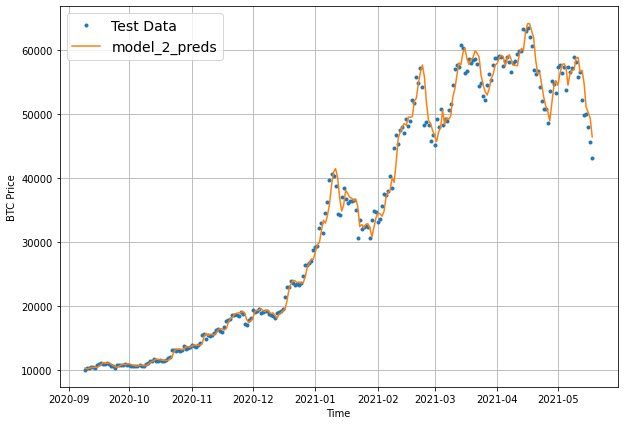

In [59]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)


In [138]:

HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [139]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [140]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output sizes)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [141]:
# Evaluate model 3
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1370.3102


1370.3101806640625

In [142]:
# Load best version of model_3
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1235.0170


1235.0169677734375

In [143]:
# Make predictions 
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:3]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[9514.45  , 9225.416 , 9238.088 , 9323.941 , 9612.45  , 9696.663 ,
        9553.135 ],
       [8890.094 , 8804.517 , 8932.921 , 9017.604 , 9253.044 , 9474.89  ,
        9312.409 ],
       [8650.551 , 8687.974 , 8960.213 , 8764.3125, 8965.679 , 9159.231 ,
        9082.58  ]], dtype=float32)>

In [144]:
# Evaluate model_3 results
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': 1235.017,
 'mse': 5298087.5,
 'rmse': 1417.3291,
 'mape': 5.556385,
 'mase': 2.1976438}

## Make our evaluation function work for larger horizons


In [177]:
# Create a function to evaluate model forecasts with various metrics
def evaluate_preds(y_true, y_pred):
  """
  Evaluates model predictions with various metrics.

  Parameters:
      y_true (tf.Tensor): True values of the target variable.
      y_pred (tf.Tensor): Predicted values of the target variable.

  Returns:
      A dictionary of evaluation metrics, including:
          - 'mae': mean absolute error
          - 'mse': mean squared error
          - 'rmse': root mean squared error
          - 'mape': mean absolute percentage error
          - 'mase': mean absolute scaled error
  """
  # Make sure float32 datatype
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [146]:
# Get model_3 results
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 1235.017,
 'mse': 5298087.5,
 'rmse': 1417.3291,
 'mape': 5.556385,
 'mase': 2.1976438}

In [147]:
model_2_results

{'mae': 633.64935,
 'mse': 1379425.5,
 'rmse': 1174.4894,
 'mape': 2.83571,
 'mase': 1.1076252}

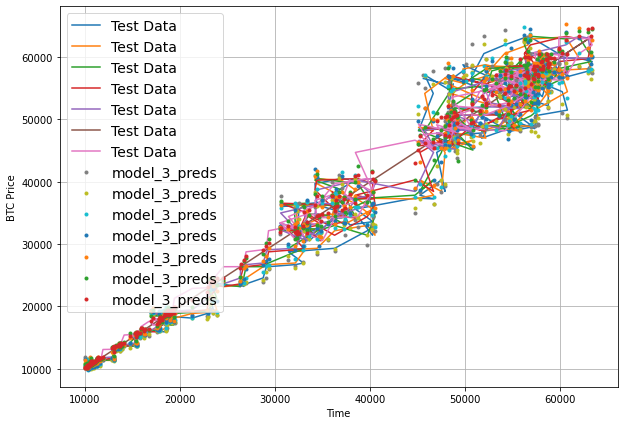

In [148]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

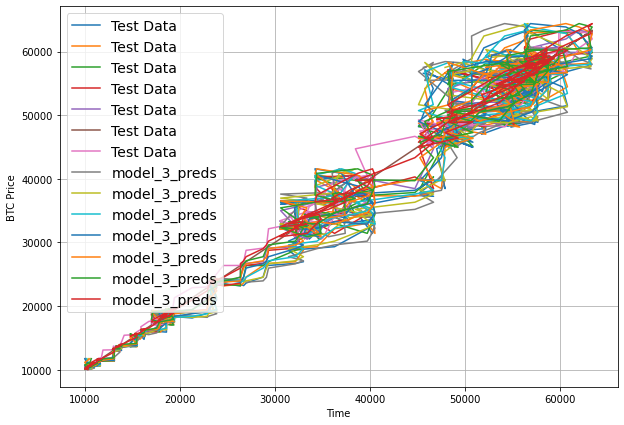

In [149]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

## Which of our models is performing the best so far?

So we've trained a few models, now let's compare them and see how they've gone...

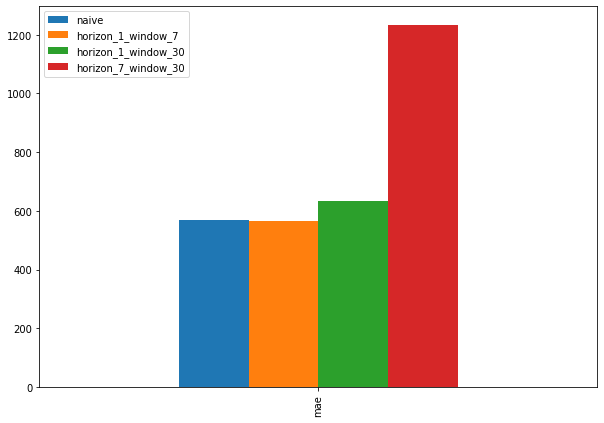

In [150]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");


> 🔑 **Note:** You might be wondering, why are the naive results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation i means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model will often get fairly good results.

> 📖 **Resources:** For more on how autocorrelation influences a model's predictions, see the arcticle [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls by Vegard Flovik.](https://www.kdnuggets.com/2020/03/machine-learning-time-series-forecasting-sequel.html)

## Model 4: Conv1D



In [73]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data

In [74]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)


(2780, 2780)

In [75]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However, our data isn't in that shape yet...


In [76]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE,)

(7,)

In [77]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [78]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) #  add an extra dimension for `input_dim`


In [79]:
# Test out our lambda layer
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [80]:
# Create Conv1D
# Set random seed
tf.random.set_seed(42)

# Create model_4
model_4 = tf.keras.Sequential([
    expand_dims_layer,
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1d")

# Compile model
model_4.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(), metrics=["mae"])


In [81]:
model_4.fit(train_windows, train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 1745.3676 - mae: 1745.3676  

18/18 [==============================] - 7s 54ms/step - loss: 1497.6587 - mae: 1497.6587 - val_loss: 1200.3894 - val_mae: 1200.3894
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 335.5406 - mae: 335.5406 - val_loss: 1617.2249 - val_mae: 1617.2249
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 236.5049 - mae: 236.5049

18/18 [==============================] - 1s 40ms/step - loss: 234.5349 - mae: 234.5349 - val_loss: 1192.4818 - val_mae: 1192.4818
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 213.0763 - mae: 213.0763

18/18 [==============================] - 1s 40ms/step - loss: 213.7812 - mae: 213.7812 - val_loss: 1164.5309 - val_mae: 1164.5309
Epoch 5/100
16/18 [=========================>....] - ETA: 0s - loss: 210.5089 - mae: 210.5089

18/18 [==============================] - 1s 40ms/step - loss: 206.7994 - mae: 206.7994 - val_loss: 1147.3881 - val_mae: 1147.3881
Epoch 6/100
14/18 [======================>.......] - ETA: 0s - loss: 203.5394 - mae: 203.5394

18/18 [==============================] - 1s 40ms/step - loss: 204.5437 - mae: 204.5437 - val_loss: 1137.7238 - val_mae: 1137.7238
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 204.2553 - mae: 204.2553

18/18 [==============================] - 1s 58ms/step - loss: 203.4492 - mae: 203.4492 - val_loss: 1109.4403 - val_mae: 1109.4403
Epoch 8/100
16/18 [=========================>....] - ETA: 0s - loss: 195.1903 - mae: 195.1903

18/18 [==============================] - 1s 41ms/step - loss: 196.6061 - mae: 196.6061 - val_loss: 1103.5115 - val_mae: 1103.5115
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 193.5800 - mae: 193.5800 - val_loss: 1114.9742 - val_mae: 1114.9742
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 189.1505 - mae: 189.1505

18/18 [==============================] - 1s 56ms/step - loss: 190.5256 - mae: 190.5256 - val_loss: 1067.6895 - val_mae: 1067.6895
Epoch 11/100
12/18 [===================>..........] - ETA: 0s - loss: 196.2473 - mae: 196.2473

18/18 [==============================] - 1s 59ms/step - loss: 186.8197 - mae: 186.8197 - val_loss: 1035.3055 - val_mae: 1035.3055
Epoch 12/100
18/18 [==============================] - 0s 8ms/step - loss: 185.5139 - mae: 185.5139 - val_loss: 1071.9446 - val_mae: 1071.9446
Epoch 13/100
18/18 [==============================] - 0s 8ms/step - loss: 180.8353 - mae: 180.8353 - val_loss: 1052.7749 - val_mae: 1052.7749
Epoch 14/100
12/18 [===================>..........] - ETA: 0s - loss: 171.3726 - mae: 171.3726

18/18 [==============================] - 1s 42ms/step - loss: 176.4556 - mae: 176.4556 - val_loss: 1004.1462 - val_mae: 1004.1462
Epoch 15/100
17/18 [===========================>..] - ETA: 0s - loss: 174.8273 - mae: 174.8273

18/18 [==============================] - 1s 41ms/step - loss: 174.6503 - mae: 174.6503 - val_loss: 993.6077 - val_mae: 993.6077
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 170.8860 - mae: 170.8860

18/18 [==============================] - 1s 40ms/step - loss: 169.2794 - mae: 169.2794 - val_loss: 946.4016 - val_mae: 946.4016
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 165.7706 - mae: 165.7706 - val_loss: 990.6719 - val_mae: 990.6719
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 163.7126 - mae: 163.7126 - val_loss: 962.1617 - val_mae: 962.1619
Epoch 19/100
16/18 [=========================>....] - ETA: 0s - loss: 161.5402 - mae: 161.5402

18/18 [==============================] - 1s 40ms/step - loss: 160.3858 - mae: 160.3858 - val_loss: 895.3848 - val_mae: 895.3848
Epoch 20/100
14/18 [======================>.......] - ETA: 0s - loss: 158.1482 - mae: 158.1482

18/18 [==============================] - 1s 40ms/step - loss: 155.6995 - mae: 155.6995 - val_loss: 864.4438 - val_mae: 864.4438
Epoch 21/100
17/18 [===========================>..] - ETA: 0s - loss: 151.7875 - mae: 151.7875

18/18 [==============================] - 1s 40ms/step - loss: 152.8894 - mae: 152.8894 - val_loss: 843.7482 - val_mae: 843.7482
Epoch 22/100
15/18 [========================>.....] - ETA: 0s - loss: 155.0821 - mae: 155.0821

18/18 [==============================] - 1s 59ms/step - loss: 149.3801 - mae: 149.3801 - val_loss: 834.5008 - val_mae: 834.5008
Epoch 23/100
16/18 [=========================>....] - ETA: 0s - loss: 143.8482 - mae: 143.8482

18/18 [==============================] - 1s 41ms/step - loss: 145.4188 - mae: 145.4188 - val_loss: 810.9647 - val_mae: 810.9647
Epoch 24/100
18/18 [==============================] - 0s 6ms/step - loss: 144.0503 - mae: 144.0503 - val_loss: 813.7907 - val_mae: 813.7907
Epoch 25/100
16/18 [=========================>....] - ETA: 0s - loss: 143.6548 - mae: 143.6548

18/18 [==============================] - 1s 41ms/step - loss: 140.2028 - mae: 140.2028 - val_loss: 770.3205 - val_mae: 770.3205
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 137.7878 - mae: 137.7878

18/18 [==============================] - 1s 40ms/step - loss: 138.0096 - mae: 138.0096 - val_loss: 757.7153 - val_mae: 757.7153
Epoch 27/100
15/18 [========================>.....] - ETA: 0s - loss: 136.1305 - mae: 136.1305

18/18 [==============================] - 1s 39ms/step - loss: 136.4755 - mae: 136.4755 - val_loss: 741.7702 - val_mae: 741.7701
Epoch 28/100
15/18 [========================>.....] - ETA: 0s - loss: 130.3989 - mae: 130.3989

18/18 [==============================] - 1s 40ms/step - loss: 132.5468 - mae: 132.5468 - val_loss: 730.3650 - val_mae: 730.3649
Epoch 29/100
16/18 [=========================>....] - ETA: 0s - loss: 129.8812 - mae: 129.8812

18/18 [==============================] - 1s 39ms/step - loss: 130.8355 - mae: 130.8355 - val_loss: 718.3738 - val_mae: 718.3738
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 133.0667 - mae: 133.0667 - val_loss: 858.0749 - val_mae: 858.0749
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 142.3133 - mae: 142.3133 - val_loss: 828.5409 - val_mae: 828.5409
Epoch 32/100
14/18 [======================>.......] - ETA: 0s - loss: 138.0087 - mae: 138.0087

18/18 [==============================] - 1s 57ms/step - loss: 136.0367 - mae: 136.0367 - val_loss: 699.7930 - val_mae: 699.7930
Epoch 33/100
12/18 [===================>..........] - ETA: 0s - loss: 130.9682 - mae: 130.9682

18/18 [==============================] - 1s 57ms/step - loss: 128.4892 - mae: 128.4892 - val_loss: 689.5143 - val_mae: 689.5143
Epoch 34/100
12/18 [===================>..........] - ETA: 0s - loss: 129.0141 - mae: 129.0141

18/18 [==============================] - 1s 46ms/step - loss: 123.6305 - mae: 123.6305 - val_loss: 683.4801 - val_mae: 683.4801
Epoch 35/100
15/18 [========================>.....] - ETA: 0s - loss: 125.0440 - mae: 125.0440

18/18 [==============================] - 1s 39ms/step - loss: 122.5790 - mae: 122.5790 - val_loss: 682.0090 - val_mae: 682.0090
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 124.6997 - mae: 124.6997 - val_loss: 709.6010 - val_mae: 709.6010
Epoch 37/100
16/18 [=========================>....] - ETA: 0s - loss: 122.4306 - mae: 122.4306

18/18 [==============================] - 1s 40ms/step - loss: 123.2967 - mae: 123.2967 - val_loss: 651.4821 - val_mae: 651.4821
Epoch 38/100
17/18 [===========================>..] - ETA: 0s - loss: 120.9755 - mae: 120.9755

18/18 [==============================] - 1s 60ms/step - loss: 120.8094 - mae: 120.8094 - val_loss: 645.4467 - val_mae: 645.4467
Epoch 39/100
17/18 [===========================>..] - ETA: 0s - loss: 118.4069 - mae: 118.4069

18/18 [==============================] - 1s 40ms/step - loss: 119.0900 - mae: 119.0900 - val_loss: 638.7908 - val_mae: 638.7908
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 119.4240 - mae: 119.4240 - val_loss: 639.6711 - val_mae: 639.6711
Epoch 41/100
17/18 [===========================>..] - ETA: 0s - loss: 121.9638 - mae: 121.9638

18/18 [==============================] - 1s 41ms/step - loss: 121.1272 - mae: 121.1272 - val_loss: 632.6451 - val_mae: 632.6451
Epoch 42/100
16/18 [=========================>....] - ETA: 0s - loss: 120.6677 - mae: 120.6677

18/18 [==============================] - 1s 39ms/step - loss: 121.3052 - mae: 121.3052 - val_loss: 625.5692 - val_mae: 625.5692
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 115.7762 - mae: 115.7762 - val_loss: 640.8463 - val_mae: 640.8463
Epoch 44/100
17/18 [===========================>..] - ETA: 0s - loss: 117.3854 - mae: 117.3854

18/18 [==============================] - 1s 39ms/step - loss: 116.7414 - mae: 116.7414 - val_loss: 618.1346 - val_mae: 618.1346
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 116.4702 - mae: 116.4702 - val_loss: 622.0591 - val_mae: 622.0591
Epoch 46/100
17/18 [===========================>..] - ETA: 0s - loss: 115.3369 - mae: 115.3369

18/18 [==============================] - 1s 39ms/step - loss: 115.9917 - mae: 115.9917 - val_loss: 615.0091 - val_mae: 615.0091
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 119.9698 - mae: 119.9698 - val_loss: 693.9296 - val_mae: 693.9296
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 114.9945 - mae: 114.9945 - val_loss: 623.5556 - val_mae: 623.5556
Epoch 49/100
18/18 [==============================] - 0s 6ms/step - loss: 114.2446 - mae: 114.2446 - val_loss: 633.7001 - val_mae: 633.7001
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 121.4340 - mae: 121.4340 - val_loss: 693.5751 - val_mae: 693.5751
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 117.8244 - mae: 117.8244 - val_loss: 675.4462 - val_mae: 675.4462
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 116.1580 - mae: 116.1580 - val_loss: 622.5123 - val_mae: 622.5123
Epoch 53/100
18/18 [============

18/18 [==============================] - 1s 38ms/step - loss: 116.5269 - mae: 116.5269 - val_loss: 601.2158 - val_mae: 601.2158
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 113.9559 - mae: 113.9559 - val_loss: 825.9791 - val_mae: 825.9791
Epoch 57/100
17/18 [===========================>..] - ETA: 0s - loss: 140.7198 - mae: 140.7198

18/18 [==============================] - 1s 39ms/step - loss: 139.8037 - mae: 139.8037 - val_loss: 596.6783 - val_mae: 596.6783
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 119.8580 - mae: 119.8580 - val_loss: 613.3223 - val_mae: 613.3223
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 111.0771 - mae: 111.0771 - val_loss: 600.5064 - val_mae: 600.5064
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 111.4315 - mae: 111.4315 - val_loss: 622.4453 - val_mae: 622.4453
Epoch 61/100
17/18 [===========================>..] - ETA: 0s - loss: 113.2049 - mae: 113.2049

18/18 [==============================] - 1s 41ms/step - loss: 111.9350 - mae: 111.9350 - val_loss: 596.4672 - val_mae: 596.4672
Epoch 62/100
11/18 [=================>............] - ETA: 0s - loss: 104.5072 - mae: 104.5072

18/18 [==============================] - 1s 57ms/step - loss: 109.9252 - mae: 109.9252 - val_loss: 587.9998 - val_mae: 587.9998
Epoch 63/100
12/18 [===================>..........] - ETA: 0s - loss: 115.6892 - mae: 115.6892

18/18 [==============================] - 1s 58ms/step - loss: 112.4272 - mae: 112.4272 - val_loss: 585.9845 - val_mae: 585.9845
Epoch 64/100
18/18 [==============================] - 0s 8ms/step - loss: 110.7150 - mae: 110.7150 - val_loss: 629.9465 - val_mae: 629.9465
Epoch 65/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5734 - mae: 115.5734 - val_loss: 588.5841 - val_mae: 588.5841
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5346 - mae: 112.5346 - val_loss: 587.4349 - val_mae: 587.4349
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9202 - mae: 108.9202 - val_loss: 612.1016 - val_mae: 612.1016
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 114.4651 - mae: 114.4651 - val_loss: 686.4443 - val_mae: 686.4443
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 127.5011 - mae: 127.5011 - val_loss: 694.7637 - val_mae: 694.7637
Epoch 70/100
18/18 [============

18/18 [==============================] - 1s 57ms/step - loss: 110.2806 - mae: 110.2806 - val_loss: 583.8397 - val_mae: 583.8397
Epoch 75/100
12/18 [===================>..........] - ETA: 0s - loss: 110.4466 - mae: 110.4466

18/18 [==============================] - 1s 44ms/step - loss: 109.6884 - mae: 109.6884 - val_loss: 577.8602 - val_mae: 577.8602
Epoch 76/100
17/18 [===========================>..] - ETA: 0s - loss: 109.7141 - mae: 109.7141

18/18 [==============================] - 1s 39ms/step - loss: 109.7963 - mae: 109.7963 - val_loss: 575.5919 - val_mae: 575.5919
Epoch 77/100
18/18 [==============================] - 0s 6ms/step - loss: 109.1113 - mae: 109.1113 - val_loss: 576.5424 - val_mae: 576.5424
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 110.1193 - mae: 110.1193 - val_loss: 577.6464 - val_mae: 577.6464
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 110.3576 - mae: 110.3576 - val_loss: 614.6218 - val_mae: 614.6218
Epoch 80/100
17/18 [===========================>..] - ETA: 0s - loss: 110.6214 - mae: 110.6214

18/18 [==============================] - 1s 40ms/step - loss: 110.1337 - mae: 110.1337 - val_loss: 574.2681 - val_mae: 574.2681
Epoch 81/100
17/18 [===========================>..] - ETA: 0s - loss: 107.7701 - mae: 107.7701

18/18 [==============================] - 1s 40ms/step - loss: 108.2240 - mae: 108.2240 - val_loss: 572.8243 - val_mae: 572.8243
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 115.1004 - mae: 115.1004 - val_loss: 576.6310 - val_mae: 576.6310
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 111.2446 - mae: 111.2446 - val_loss: 677.4390 - val_mae: 677.4390
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 113.7795 - mae: 113.7795 - val_loss: 580.3452 - val_mae: 580.3452
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 108.1003 - mae: 108.1003 - val_loss: 588.4471 - val_mae: 588.4471
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 109.0619 - mae: 109.0619 - val_loss: 617.9746 - val_mae: 617.9746
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 112.7684 - mae: 112.7684 - val_loss: 580.7747 - val_mae: 580.7747
Epoch 88/100
18/18 [============

18/18 [==============================] - 1s 40ms/step - loss: 107.8600 - mae: 107.8600 - val_loss: 568.4855 - val_mae: 568.4855
Epoch 99/100
13/18 [====================>.........] - ETA: 0s - loss: 103.2903 - mae: 103.2903

18/18 [==============================] - 1s 39ms/step - loss: 107.9564 - mae: 107.9564 - val_loss: 567.9080 - val_mae: 567.9080
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 109.7374 - mae: 109.7374 - val_loss: 626.4501 - val_mae: 626.4501


In [82]:
model_4.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 626.4500 - mae: 626.4500


[626.4500122070312, 626.4500122070312]

In [84]:
# Load back in best performing Conv1D model and evaluate
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1d/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 567.9080 - mae: 567.9080


[567.907958984375, 567.907958984375]

In [85]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8902.077, 8809.027, 9021.502, 8800.975, 8770.296, 8755.672,
       8692.764, 8555.119, 8480.791, 8535.252], dtype=float32)>

In [86]:
# Evaluate predictions
model_4_results = evaluate_preds(tf.squeeze(test_labels), model_4_preds)
model_4_results

{'mae': 567.90796,
 'mse': 1176493.4,
 'rmse': 1084.6628,
 'mape': 2.5428576,
 'mase': 0.997657}

In [87]:
model_1_results

{'mae': 567.0257,
 'mse': 1164036.9,
 'rmse': 1078.9054,
 'mape': 2.549461,
 'mase': 0.9961071}

## Model_5: RNN (LSTM)


In [88]:
tf.random.set_seed(42)

# Create LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

# Fit model
model_5_history = model_5.fit(train_windows, train_labels,
                              batch_size=128,
                              epochs=100,
                              verbose=0,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [89]:
# Evaluate model 5
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 589.8726


589.8726196289062

In [90]:
# Load best performing model and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.5698


585.56982421875

In [91]:
model_5_preds = make_preds(model_5, test_windows)

18/18 [==============================] - 0s 2ms/step


In [92]:
model_5_results = evaluate_preds(tf.squeeze(test_labels, axis=1), model_5_preds)
model_5_results

{'mae': 585.5699,
 'mse': 1234924.0,
 'rmse': 1111.2714,
 'mape': 2.650585,
 'mase': 1.0286841}

In [93]:
model_1_results

{'mae': 567.0257,
 'mse': 1164036.9,
 'rmse': 1078.9054,
 'mape': 2.549461,
 'mase': 0.9961071}

> 🔑 **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the bitcoin halving events?

In [94]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [95]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [96]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [97]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None



In [98]:
# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [99]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [100]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


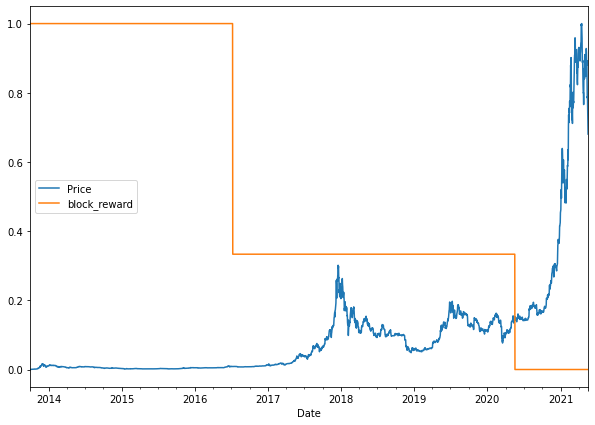

In [101]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

In [102]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE= 7

In [103]:
# Make a copy of the bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()


In [104]:
# Add windowed columns
for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```


In [105]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [106]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [107]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [108]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae", optimizer="adam")

# Fit model
model_6_history = model_6.fit(X_train, y_train,
                              batch_size=128,
                              epochs=100,
                              verbose=1,
                              validation_data=(X_test, y_test),
                              callbacks=[create_model_checkpoint(model_6.name)])

Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 3040.3398 

18/18 [==============================] - 2s 49ms/step - loss: 2772.6943 - val_loss: 7058.3325
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 846.7609

18/18 [==============================] - 0s 26ms/step - loss: 462.5723 - val_loss: 1926.0692
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 264.6462

18/18 [==============================] - 0s 25ms/step - loss: 231.4295 - val_loss: 1016.4352
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 192.4401 - val_loss: 1020.6617
Epoch 5/100
16/18 [=========================>....] - ETA: 0s - loss: 183.7509

18/18 [==============================] - 0s 27ms/step - loss: 181.1164 - val_loss: 1004.1743
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 137.1733

18/18 [==============================] - 0s 26ms/step - loss: 183.9578 - val_loss: 998.4591
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 217.1401

18/18 [==============================] - 0s 26ms/step - loss: 181.6732 - val_loss: 975.2792
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 157.1734

18/18 [==============================] - 1s 47ms/step - loss: 173.9920 - val_loss: 974.5778
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 141.5370

18/18 [==============================] - 0s 28ms/step - loss: 170.1214 - val_loss: 970.0840
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 182.4557

18/18 [==============================] - 0s 28ms/step - loss: 165.8165 - val_loss: 914.0477
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 184.2823

18/18 [==============================] - 0s 26ms/step - loss: 161.7340 - val_loss: 893.7469
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 157.7723 - val_loss: 933.4061
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 122.8553

18/18 [==============================] - 0s 27ms/step - loss: 155.3055 - val_loss: 870.4786
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 164.5183

18/18 [==============================] - 0s 26ms/step - loss: 150.3781 - val_loss: 850.3763
Epoch 15/100
18/18 [==============================] - 0s 5ms/step - loss: 150.4370 - val_loss: 906.7751
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 141.2794

18/18 [==============================] - 0s 28ms/step - loss: 147.5973 - val_loss: 804.8990
Epoch 17/100
18/18 [==============================] - ETA: 0s - loss: 144.6483

18/18 [==============================] - 0s 28ms/step - loss: 144.6483 - val_loss: 790.0992
Epoch 18/100
18/18 [==============================] - 0s 5ms/step - loss: 139.6376 - val_loss: 821.5746
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 79.4235

18/18 [==============================] - 0s 26ms/step - loss: 137.3666 - val_loss: 762.0845
Epoch 20/100
18/18 [==============================] - 0s 4ms/step - loss: 137.7742 - val_loss: 803.6147
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 198.0636

18/18 [==============================] - 0s 26ms/step - loss: 137.9327 - val_loss: 734.1343
Epoch 22/100
16/18 [=========================>....] - ETA: 0s - loss: 136.5280

18/18 [==============================] - 0s 27ms/step - loss: 134.8144 - val_loss: 728.9628
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 138.1049

18/18 [==============================] - 0s 27ms/step - loss: 129.6372 - val_loss: 721.3059
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 144.8018

18/18 [==============================] - 0s 27ms/step - loss: 128.6411 - val_loss: 715.1678
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 135.2744

18/18 [==============================] - 0s 25ms/step - loss: 127.0610 - val_loss: 705.0263
Epoch 26/100
18/18 [==============================] - 0s 4ms/step - loss: 129.8863 - val_loss: 709.9615
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 189.0013

18/18 [==============================] - 1s 35ms/step - loss: 128.7119 - val_loss: 680.1329
Epoch 28/100
18/18 [==============================] - 0s 6ms/step - loss: 123.3980 - val_loss: 688.7647
Epoch 29/100
17/18 [===========================>..] - ETA: 0s - loss: 119.9032

18/18 [==============================] - 1s 39ms/step - loss: 122.1537 - val_loss: 676.9201
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 124.9493 - val_loss: 770.3508
Epoch 31/100
18/18 [==============================] - 0s 7ms/step - loss: 131.4637 - val_loss: 787.1359
Epoch 32/100
16/18 [=========================>....] - ETA: 0s - loss: 127.5287

18/18 [==============================] - 1s 38ms/step - loss: 129.2915 - val_loss: 654.0768
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 122.4093 - val_loss: 654.6836
Epoch 34/100
17/18 [===========================>..] - ETA: 0s - loss: 118.5406

18/18 [==============================] - 0s 27ms/step - loss: 119.0776 - val_loss: 649.5664
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 119.2359 - val_loss: 681.1141
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 126.5224 - val_loss: 713.6338
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 158.0462

18/18 [==============================] - 0s 25ms/step - loss: 119.4251 - val_loss: 640.8547
Epoch 38/100
 1/18 [>.............................] - ETA: 0s - loss: 108.2842

18/18 [==============================] - 0s 27ms/step - loss: 116.3583 - val_loss: 629.1211
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 116.9880 - val_loss: 648.2843
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 112.9285

18/18 [==============================] - 1s 47ms/step - loss: 115.0196 - val_loss: 621.7812
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 108.2261

18/18 [==============================] - 0s 29ms/step - loss: 115.2499 - val_loss: 617.4124
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 113.0531

18/18 [==============================] - 0s 28ms/step - loss: 118.8081 - val_loss: 614.9828
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7093 - val_loss: 631.2520
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 115.7861 - val_loss: 673.4985
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 116.7450 - val_loss: 623.3842
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 87.7773

18/18 [==============================] - 0s 29ms/step - loss: 114.8643 - val_loss: 605.9474
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7104 - val_loss: 667.6683
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 112.6499 - val_loss: 627.6312
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 159.5122

18/18 [==============================] - 0s 28ms/step - loss: 114.2608 - val_loss: 603.6273
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4419 - val_loss: 609.3578
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4461 - val_loss: 607.0852
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 112.7933 - val_loss: 635.1485
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 115.5027 - val_loss: 606.0590
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 113.1865 - val_loss: 655.5964
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 112.8221 - val_loss: 605.0167
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 111.2824 - val_loss: 767.8895
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 126.6128 - val_loss: 746.8075
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 12

18/18 [==============================] - 0s 28ms/step - loss: 111.0126 - val_loss: 592.5309
Epoch 63/100
18/18 [==============================] - 0s 4ms/step - loss: 109.8607 - val_loss: 594.5026
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6823 - val_loss: 695.3754
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 117.0231 - val_loss: 613.8671
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 114.2990 - val_loss: 598.0774
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1347 - val_loss: 664.8840
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 112.2733 - val_loss: 676.3120
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 125.1451 - val_loss: 705.8503
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 119.1532 - val_loss: 593.1167
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 11

18/18 [==============================] - 0s 27ms/step - loss: 109.5021 - val_loss: 588.1154
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4238 - val_loss: 593.4743
Epoch 74/100
 1/18 [>.............................] - ETA: 0s - loss: 165.6156

18/18 [==============================] - 0s 28ms/step - loss: 108.8664 - val_loss: 584.3824
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 108.5478 - val_loss: 614.1201
Epoch 76/100
 1/18 [>.............................] - ETA: 0s - loss: 81.9613

18/18 [==============================] - 0s 27ms/step - loss: 109.6252 - val_loss: 580.9164
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6636 - val_loss: 581.4627
Epoch 78/100
 1/18 [>.............................] - ETA: 0s - loss: 107.1268

18/18 [==============================] - 0s 27ms/step - loss: 107.0004 - val_loss: 578.4968
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 107.0746 - val_loss: 581.1063
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 107.4028 - val_loss: 579.9352
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 107.7107 - val_loss: 580.5665
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9063 - val_loss: 594.9701
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 108.9641 - val_loss: 631.4254
Epoch 84/100
16/18 [=========================>....] - ETA: 0s - loss: 108.6254

18/18 [==============================] - 1s 43ms/step - loss: 108.8892 - val_loss: 575.8528
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 106.8453 - val_loss: 605.6979
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 111.0361 - val_loss: 651.0648
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 107.8113 - val_loss: 582.5484
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 106.9631 - val_loss: 576.0182
Epoch 89/100
14/18 [======================>.......] - ETA: 0s - loss: 101.6329

18/18 [==============================] - 1s 38ms/step - loss: 107.8355 - val_loss: 574.4097
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 106.8996 - val_loss: 680.5468
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 113.8970 - val_loss: 608.4774
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 109.1333 - val_loss: 576.7826
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 113.0221 - val_loss: 622.7986
Epoch 94/100
 1/18 [>.............................] - ETA: 0s - loss: 146.1802

18/18 [==============================] - 0s 26ms/step - loss: 108.1395 - val_loss: 572.4614
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 105.9609 - val_loss: 579.4247
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 109.1512 - val_loss: 611.0909
Epoch 97/100
18/18 [==============================] - 0s 4ms/step - loss: 107.2760 - val_loss: 573.6799
Epoch 98/100
18/18 [==============================] - 0s 4ms/step - loss: 106.3926 - val_loss: 574.3871
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 148.5973

18/18 [==============================] - 0s 28ms/step - loss: 106.2966 - val_loss: 571.0638
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 111.7895 - val_loss: 644.3596


In [109]:
# Evaluate model
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 644.3596


644.359619140625

In [110]:
# Load in and evaluate best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate/")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 571.0638


571.0638427734375

In [111]:
# Make predictions
model_6_preds = make_preds(model_6, X_test)
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8850.318, 8768.235, 8989.102, 8721.777, 8729.796, 8731.256,
       8658.062, 8486.322, 8455.289, 8497.675], dtype=float32)>

In [112]:
# Get results
model_6_results = evaluate_preds(y_test, model_6_preds)
model_6_results

{'mae': 571.06384,
 'mse': 1173863.5,
 'rmse': 1083.4498,
 'mape': 2.5603414,
 'mase': 1.003201}

In [113]:
model_1_results

{'mae': 567.0257,
 'mse': 1164036.9,
 'rmse': 1078.9054,
 'mape': 2.549461,
 'mase': 0.9961071}

## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasting model we've build so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper: https://arxiv.org/pdf/1905.10437.pdf

Why?

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results on our problem



### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow. we've got to create it.

To create custom layers and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [114]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connect layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


Let's test our NBeatsBlock class.

To do we'll make some dummy inputs and outputs.

In [115]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [116]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [117]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")


Backcast: [-0.2672973   0.00415564  0.28384024 -0.0391544  -0.42204753 -0.2742598
 -0.1650837 ]
Forecast: -0.08319779485464096


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data_performance



In [118]:
HORIZON = 1
WINDOW_SIZE = 7

In [119]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series)


In [120]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [121]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

In [122]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters, many of them can be found in Table 18: https://arxiv.org/pdf/1905.10437.pdf

In [124]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
BATCH_SIZE = 1024
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network

https://paperswithcode.com/method/resnet

In [127]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)
subtracted = layers.subtract([tensor_1, tensor_2])
added = layers.add([tensor_1, tensor_2])

In [126]:
tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>)

In [128]:
subtracted.numpy(), added.numpy()

(array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32),
 array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32))

### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N_BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts forr the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create a double residuel stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper use mutiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)


In [132]:
%%time
tf.random.set_seed(42)

# 1. Setup an instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create an input layer for the N_BEATS stack
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards prediction + horizon prediction)
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)
  
  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass in the residuals

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model
model_7.compile(loss="mae",
                optimizer="adam",
                metrics=["mae"])

# 9. Fit the model
model_7_history = model_7.fit(train_dataset,
                              batch_size=BATCH_SIZE,
                              epochs=N_EPOCHS,
                              validation_data=test_dataset,
                              verbose=0,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                          patience=200,
                                                                          restore_best_weights=True),
                                         tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                              patience=100,
                                                                              verbose=1)])


Epoch 858: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1136: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1236: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 4min 51s, sys: 7.32 s, total: 4min 58s
Wall time: 6min 16s


In [133]:
# Evaluate N-Beats model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 572.5068 - mae: 572.5068


[572.5067749023438, 572.5067749023438]

In [134]:
# Make predictions with N-Beats model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8841.001 , 8780.61  , 9028.251 , 8745.8125, 8734.368 , 8746.628 ,
       8654.339 , 8497.634 , 8469.702 , 8510.525 ], dtype=float32)>

In [135]:
# Evaluate NBEATS model preds
model_7_results = evaluate_preds(y_test, model_7_preds)
model_7_results

{'mae': 572.5068,
 'mse': 1165955.4,
 'rmse': 1079.7941,
 'mape': 2.5936737,
 'mase': 1.0057359}

In [136]:
model_1_results

{'mae': 567.0257,
 'mse': 1164036.9,
 'rmse': 1078.9054,
 'mape': 2.549461,
 'mase': 0.9961071}

Woah... even with all of those special layers and hand-crafted network, it looks like the N-Beats model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

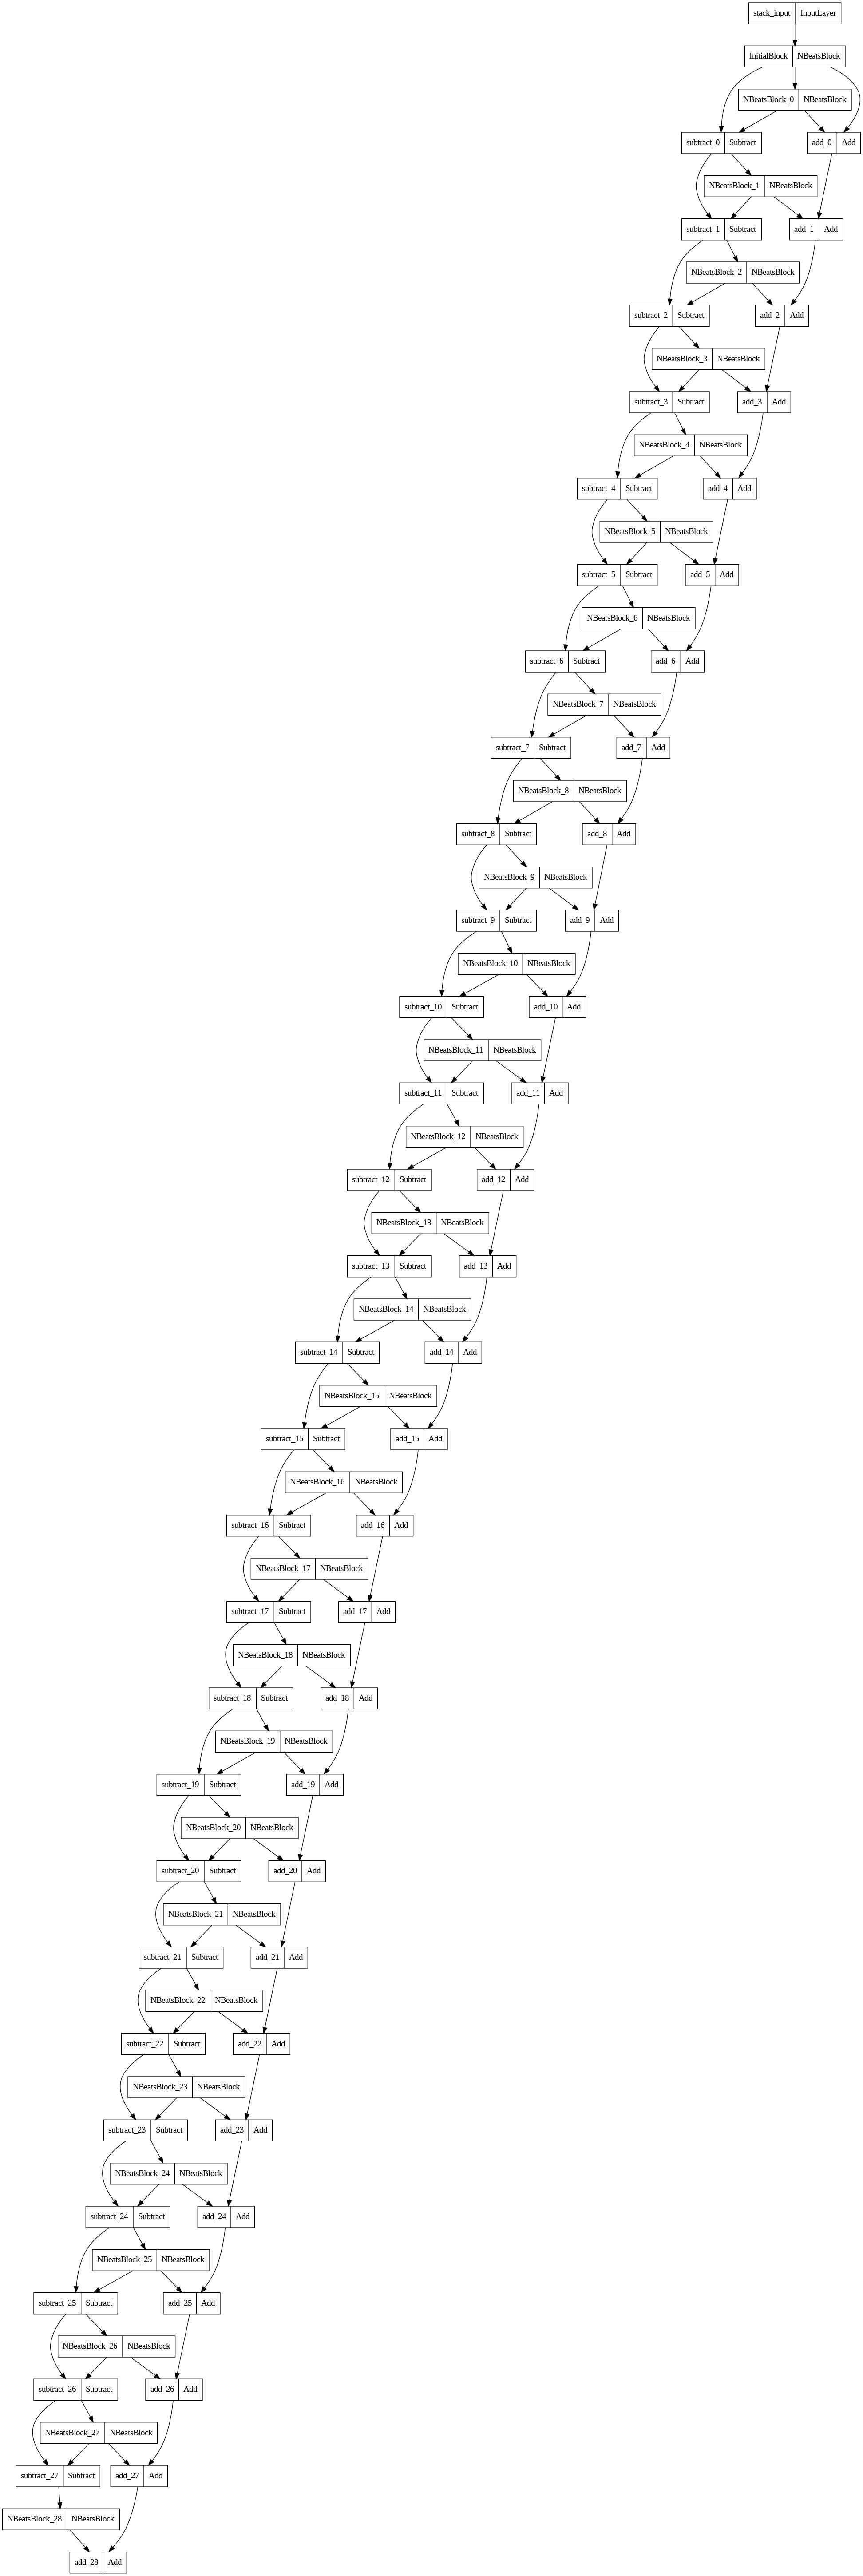

In [137]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

it combines many *different* models to predict a common goal.

In [253]:
HORIZON = 1
WINDOW_SIZE = 7

### Constructing and fitting an ensemble of models (using different loss functions)

In [254]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  """
  # Make empty list for trained ensemble models
  ensemble_models= []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [255]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 636: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 768: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 868: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 412: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 512: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 192: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 600: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 700: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 992: ReduceLROnPl

In [256]:
ensemble_models

In [257]:
len(ensemble_models)

15

### Make predictions with our ensemble model

In [258]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [259]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)

1/1 [==============================] - 0s 38ms/step
CPU times: user 700 ms, sys: 36.4 ms, total: 736 ms
Wall time: 872 ms


In [260]:
len(ensemble_preds), ensemble_preds.shape

(15, TensorShape([15, 556]))

In [261]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8791.871, 8772.607, 9054.62 , 8725.95 , 8737.659, 8715.885,
       8657.614, 8472.924, 8451.626, 8512.732], dtype=float32)>

In [262]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8795.307, 8784.609, 9061.994, 8722.672, 8745.745, 8739.626,
       8651.859, 8476.961, 8460.775, 8518.256], dtype=float32)

In [263]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_mean)
ensemble_results

{'mae': 569.3508,
 'mse': 1146242.9,
 'rmse': 1070.6273,
 'mape': 2.5849814,
 'mase': 1.0001917}

In [264]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=ensemble_median)
ensemble_results
     

{'mae': 570.4837,
 'mse': 1152432.8,
 'rmse': 1073.5142,
 'mape': 2.586291,
 'mase': 1.0021819}

In [265]:
model_1_results

{'mae': 567.0257,
 'mse': 1164036.9,
 'rmse': 1078.9054,
 'mape': 2.549461,
 'mase': 0.9961071}

### Plotting the prediction intervals (uncertaintly estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standart deviations of the mean)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

* https://en.wikipedia.org/wiki/97.5th_percentile_point
* https://eng.uber.com/neural-networks-uncertainty-estimation/


In [266]:
tf.math.reduce_std(ensemble_preds, axis=0)

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 43.013706,  30.866047,  30.26159 ,  45.015156,  49.384106,
        61.170937,  32.542812,  38.423336,  44.14485 ,  23.781244,
        35.03708 ,  36.464344,  33.18305 ,  33.73468 ,  44.58328 ,
        37.522648,  40.291664,  31.145916,  40.24146 ,  48.364315,
        44.735527,  40.09959 ,  41.64553 ,  28.612644,  40.379616,
        24.672522,  30.45153 ,  35.113895,  34.90878 ,  32.744347,
        29.287418,  32.13872 ,  24.332743,  20.494802,  20.904444,
        28.463675,  33.829777,  28.197136,  29.280146,  29.728777,
        57.64917 ,  62.737186,  72.64177 ,  79.06364 ,  44.778923,
        29.872505,  38.53258 ,  22.7171  ,  23.844471,  27.471615,
        24.65169 ,  24.068441,  29.728117,  28.70525 ,  26.142073,
        23.114351,  34.829655,  41.545273,  39.165077,  41.779655,
        43.357414,  25.173044,  26.16437 ,  39.233902,  31.254093,
        33.538685,  38.70145 ,  55.32757 ,  37.953773,  40.792038,
        41.717

In [267]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly intialized models

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # 4. Get the prediction interval upper and lower bounds 
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper
     

In [268]:
# Get the upper and lower bounds of the 95% percent prediction interval
lower, upper = get_upper_lower(preds=ensemble_preds)

> 📖 **Resource:** Many of the steps we've taken above have inspired/referenced from the Machine Learning Mastery blog post on [Prediction Intervals for Deep Learning Neural Networks](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/)

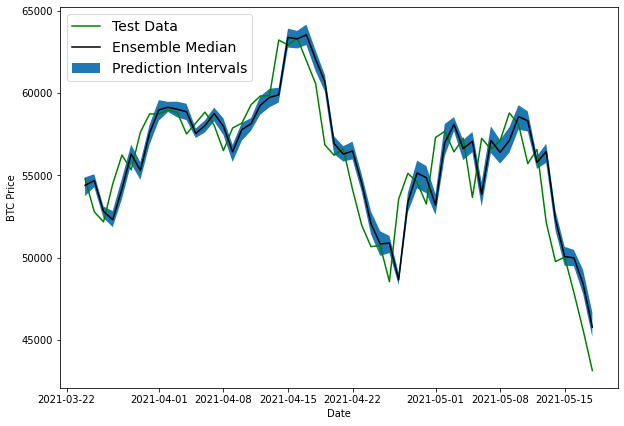

In [269]:
# Get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
# To plot the upper and lower bounds, let's use fill_between: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

Hmm...

So far all of our models predictions have been lagging behind the test data...

As is they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> 🔑 **Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Aside: two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know? (what can a model never predict? Or would it helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning you should know about:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred as data uncertainty or subway uncertainty
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it also referred to as "model" or "coconut" uncertainty

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture.

Let's now build a model which is capable of predicting into the future!

In [272]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [282]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()
# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [283]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [284]:
tf.random.set_seed(42)

# Build model
model_9 = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ], name="model_9_future")

      # Compile simple model with current loss function
model_9.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(), metrics=["mae", "mse"])

# Fit model
model_9_history = model_9.fit(dataset_all,
                              epochs=100,
                              verbose=0)

### Make predictions into future

In [285]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14


To make predictions into the future we want a function which:

1. Takes as input:
  * a list of values (Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on.
2. Creates an empty list for future forecasts this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values.
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction.

In [302]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """
  # 2. Create and empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
  for _ in range(INTO_FUTURE):
    # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"2021-05-{18+_} Predicting on:\n  {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecast


⚒️ **Exercise:** In terms of a forecasting model, what might another approach to our make_future_forecasts() function? Recall, that for making forecasts, you need to retrain a model each time you want to generate a new prediction.

So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc.

 As it is, the make_future_forecasts() function skips the retraining of a model part.

In [303]:
# Make forecasts into the future
future_forecast =  make_future_forecasts(values=y_all,
                                         model=model_9,
                                         into_future=INTO_FUTURE,
                                         window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 27ms/step
2021-05-18 Predicting on:
  [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 54840.078125

1/1 [==============================] - 0s 25ms/step
2021-05-19 Predicting on:
  [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 54840.078125  ] -> Prediction: 50641.6015625

1/1 [==============================] - 0s 24ms/step
2021-05-20 Predicting on:
  [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 54840.078125   50641.6015625 ] -> Prediction: 54565.8828125

1/1 [==============================] - 0s 24ms/step
2021-05-21 Predicting on:
  [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 54840.078125   50641.6015625  54565.8828125 ] -> Prediction: 49064.796875

1/1 [==============================] - 0s 24ms/step
2021-05-22 Predicting on:
  [47885.62525472 45604.61575361 43144.47129086 5484

In [304]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


### Plot future forecasts

In [306]:
future_forecast

[54840.08,
 50641.6,
 54565.883,
 49064.797,
 48228.008,
 40334.863,
 47548.293,
 49998.406,
 56528.426,
 53097.914,
 52889.83,
 42656.86,
 40146.65,
 44525.273]

In [311]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values ranging from start_date to start_date+into_future
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [312]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep
np.timedelta64

numpy.timedelta64

In [313]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [315]:
# Insert last timestep/final price into next time steps and future forecasts so the plot doesn't look janky
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])

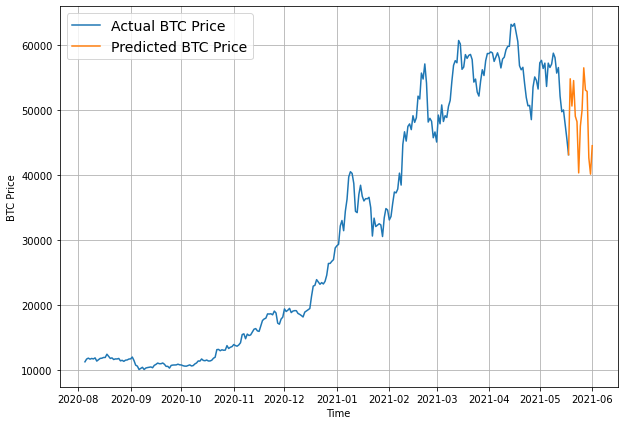

In [316]:
# Plot future prices predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")